In [3]:
# =========================
# 0) Use only GPU 0 (make GPU 1 idle) + quiet tokenizers
# =========================
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# =========================
# 1) GPU info
# =========================
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-cd97d78d-e35b-f00f-6120-e3d2eb5268a3)
GPU 1: Tesla T4 (UUID: GPU-93080243-8fd4-b5c4-8fab-4e0faeeb81fc)
Tue Sep  2 10:17:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|         

In [5]:
# =========================
# 2) Install core deps (Unsloth + HF + XAI)
# =========================
!pip -q install --upgrade pip
!pip -q install "unsloth>=2024.6.0" "transformers>=4.56.0" "accelerate>=1.1.1" \
                "peft>=0.11.0" "bitsandbytes>=0.43.0" datasets evaluate \
                scikit-learn pandas numpy matplotlib shap lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.8.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.8.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [6]:
# =========================
# 3) Runtime diagnostics
# =========================
import torch, platform, sys
print("\n=== Versions ===")
print("Python   :", sys.version.split()[0])
print("Platform :", platform.platform())
print("Torch    :", torch.__version__)
print("CUDA avail?", torch.cuda.is_available())
print("GPU count :", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")

import transformers, bitsandbytes, datasets, evaluate, sklearn
import unsloth, peft
print("Transformers:", transformers.__version__)
print("Unsloth     :", unsloth.__version__)
print("bitsandbytes:", bitsandbytes.__version__)
print("PEFT        :", peft.__version__)
print("datasets    :", datasets.__version__)
print("evaluate    :", evaluate.__version__)
print("sklearn     :", sklearn.__version__)
bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
print("bf16 supported?", bf16)


=== Versions ===
Python   : 3.11.13
Platform : Linux-6.6.56+-x86_64-with-glibc2.35
Torch    : 2.8.0+cu128
CUDA avail? True
GPU count : 1
  - GPU 0: Tesla T4


2025-09-02 10:21:17.080940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756808477.291923      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756808477.355965      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_36/2959996224.py:16: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  import unsloth, peft


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Transformers: 4.56.0
Unsloth     : 2025.8.10
bitsandbytes: 0.47.0
PEFT        : 0.15.2
datasets    : 3.6.0
evaluate    : 0.4.5
sklearn     : 1.2.2
bf16 supported? False


In [7]:
# =========================
# 4) Fetch ServeNet + build Top-50
# =========================
import json, re, pandas as pd
from pathlib import Path
import urllib.request

BASE_DIR = Path("/kaggle/working")
DATA_DIR = BASE_DIR / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RAW_TXT = BASE_DIR / "ProgrammWebScrapy.txt"
TOP_N = 50
TOP_CSV    = DATA_DIR / f"Top_{TOP_N}_Web_Services_Categories.csv"
TOP_COUNTS = DATA_DIR / f"Top_{TOP_N}_label_counts.csv"

urls = [
    "https://raw.githubusercontent.com/fred8617/ServeNet/master/Data/ProgrammWebScrapy.txt",
    "https://raw.githubusercontent.com/yylonly/ServeNet/master/WebScrapyForAPI/ProgrammWebScrapy.txt",
    "https://raw.githubusercontent.com/yylonly/ServeNet/master/Data/ProgrammWebScrapy.txt",
]
if not RAW_TXT.exists():
    ok = False
    for u in urls:
        try:
            print("Trying:", u)
            urllib.request.urlretrieve(u, RAW_TXT)
            with open(RAW_TXT, "r", encoding="utf-8") as f: _ = f.read(200)
            print("Downloaded →", RAW_TXT)
            ok = True; break
        except Exception as e:
            print("Failed:", e)
    if not ok:
        raise SystemExit("❌ Could not download ProgrammWebScrapy.txt — please upload manually.")

def return_json_from_txt(p: Path):
    with open(p, encoding='utf-8') as f: return json.loads(f.read(), strict=False)

def extract_df(data, desc_key='Description', cat_key='PrimaryCategory'):
    df = pd.DataFrame(data)[[desc_key, cat_key]].copy()
    df.columns = ['Service Description', 'Service Classification']
    df['Service Description'] = df['Service Description'].astype(str).str.strip().str.replace(r"\s+"," ", regex=True)
    return df

def filter_top_n(df, label_col='Service Classification', top_n=50):
    vc = df[label_col].value_counts()
    top_labels = vc.head(top_n).index.tolist()
    filtered = df[df[label_col].isin(top_labels)].copy()
    counts = vc[top_labels]; counts.name = "Frequency"
    return filtered, counts

if not TOP_CSV.exists():
    data = return_json_from_txt(RAW_TXT)
    df_all = extract_df(data)
    df_top, counts = filter_top_n(df_all, top_n=TOP_N)
    df_top.to_csv(TOP_CSV, index=False, encoding='utf-8')
    counts.reset_index().rename(columns={'index':'Service Classification'}).to_csv(TOP_COUNTS, index=False)
    print("Saved:", TOP_CSV, "and", TOP_COUNTS)
else:
    df_top = pd.read_csv(TOP_CSV)

print(df_top.head(3))
print("\n#classes:", df_top['Service Classification'].nunique())
print("\nTop-10 classes:\n", df_top['Service Classification'].value_counts().head(10))

                                 Service Description Service Classification
0  Google Maps' services have been split into mul...                Mapping
1  It has been split into multiple APIs, includin...                 Social
2  The Data API allows users to integrate their p...                  Video

#classes: 50

Top-10 classes:
 Service Classification
Tools         767
Financial     687
Messaging     511
eCommerce     466
Payments      460
Social        433
Enterprise    412
Mapping       362
Government    304
Telephony     300
Name: count, dtype: int64


In [8]:
# =========================
# 5) Split + label encoding
# =========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = df_top.copy()
le = LabelEncoder()
df['label'] = le.fit_transform(df['Service Classification'])
id2label = {i:l for i,l in enumerate(le.classes_)}
label2id = {l:i for i,l in id2label.items()}

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print("Shapes:", train_df.shape, val_df.shape, test_df.shape)
print("Example:\n", train_df[['Service Description','Service Classification']].head(2))
print("\n#Unique classes:", len(id2label))

Shapes: (8768, 3) (1096, 3) (1096, 3)
Example:
                                    Service Description Service Classification
206  True Knowledge is a new class of Internet sear...                 Search
861  Real Estate Cloud provides various services fo...            Real Estate

#Unique classes: 50


In [10]:
# =========================
# 6) Tokenizer + HF datasets (robust to NaN/None)
# =========================
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

MODEL_NAME = "unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Ensure clean text (no NaN/None)
def _clean_series(s):
    return s.astype(str).fillna("").str.strip().str.replace(r"\s+", " ", regex=True)

train_df_clean = train_df.copy()
val_df_clean   = val_df.copy()
test_df_clean  = test_df.copy()

train_df_clean["Service Description"] = _clean_series(train_df_clean["Service Description"])
val_df_clean["Service Description"]   = _clean_series(val_df_clean["Service Description"])
test_df_clean["Service Description"]  = _clean_series(test_df_clean["Service Description"])

# Build HF datasets
train_ds = Dataset.from_pandas(
    train_df_clean[["Service Description","label"]].rename(columns={"Service Description":"text"}).reset_index(drop=True)
)
val_ds = Dataset.from_pandas(
    val_df_clean[["Service Description","label"]].rename(columns={"Service Description":"text"}).reset_index(drop=True)
)
test_ds = Dataset.from_pandas(
    test_df_clean[["Service Description","label"]].rename(columns={"Service Description":"text"}).reset_index(drop=True)
)

def tokenize_batch(batch):
    # Force every entry to plain str; replace None/NaN with ""
    texts = [t if isinstance(t, str) else ("" if t is None else str(t)) for t in batch["text"]]
    return tokenizer(texts, truncation=True, padding=False, max_length=256)

train_tok = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
val_tok   = val_ds.map(tokenize_batch,   batched=True, remove_columns=["text"])
test_tok  = test_ds.map(tokenize_batch,  batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("Tokenized sizes:", len(train_tok), len(val_tok), len(test_tok))
print("Example enc keys:", train_tok[0].keys())

Map:   0%|          | 0/8768 [00:00<?, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Tokenized sizes: 8768 1096 1096
Example enc keys: dict_keys(['label', 'input_ids', 'attention_mask'])


In [15]:
# ==== Hard-disable any mixed precision so no GradScaler is created ====
import os, gc, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"           # single GPU
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"    # <-- critical: disable mp for accelerate
os.environ["HF_EVALUATE_OFFLINE"] = "1"            # quieter eval downloads

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")

# ==== Imports AFTER env flags ====
import numpy as np, evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import accelerate, transformers

print("Torch        :", torch.__version__)
print("Transformers :", transformers.__version__)
print("Accelerate   :", accelerate.__version__)
print("ACCELERATE_MIXED_PRECISION =", os.environ.get("ACCELERATE_MIXED_PRECISION"))

# --- tiny hotpatch so HF Trainer doesn't touch parallelism_config path ---
if not hasattr(accelerate.Accelerator, "parallelism_config"):
    accelerate.Accelerator.parallelism_config = property(lambda self: None)

MODEL_NAME = "unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit"
num_labels = len(id2label)

# ==== Load model (4-bit base), keep heads in fp32 ====
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float32,           # ensure classifier head params are fp32
)

# Pad token fix
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if getattr(model.config, "pad_token_id", None) is None:
    model.config.pad_token_id = tokenizer.pad_token_id
print("pad_token_id:", model.config.pad_token_id)

# Optional: gradient checkpointing to save VRAM (safe with fp32 head)
if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()

# ==== LoRA adapters (train only adapters in fp32) ====
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8, lora_alpha=32, lora_dropout=0.1,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","down_proj","up_proj"],
)
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()

# ==== Metrics ====
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":         accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision_macro":  precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall_macro":     recall.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1_macro":         f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# ==== Trainer args (NO fp16/bf16) ====
args = TrainingArguments(
    output_dir="/kaggle/working/unsloth_runs_singlegpu",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_ratio=0.05,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=False,               # ensure no GradScaler path
    bf16=False,               # T4 doesn't support bf16
    dataloader_num_workers=2,
    report_to=[],
    ddp_find_unused_parameters=False,
    optim="paged_adamw_8bit",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,   # deprecation warning OK
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_out  = trainer.train()
val_metrics = trainer.evaluate()
val_metrics

`torch_dtype` is deprecated! Use `dtype` instead!


Torch        : 2.8.0+cu128
Transformers : 4.56.0
Accelerate   : 1.8.1
ACCELERATE_MIXED_PRECISION = no


Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pad_token_id: 151654
trainable params: 9,309,184 || all params: 1,553,100,288 || trainable%: 0.5994


/tmp/ipykernel_36/2593677609.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,20.648800,2.568641,0.363139,0.344026,0.258840,0.270824


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.568641185760498,
 'eval_accuracy': 0.36313868613138683,
 'eval_precision_macro': 0.3440255727810721,
 'eval_recall_macro': 0.2588403802540055,
 'eval_f1_macro': 0.27082352740065907,
 'eval_runtime': 184.4137,
 'eval_samples_per_second': 5.943,
 'eval_steps_per_second': 1.486,
 'epoch': 1.0}

TEST METRICS: {'eval_loss': 2.518556833267212, 'eval_accuracy': 0.36678832116788324, 'eval_precision_macro': 0.35280752069348303, 'eval_recall_macro': 0.2594085998286511, 'eval_f1_macro': 0.2655142414402409, 'eval_runtime': 186.0122, 'eval_samples_per_second': 5.892, 'eval_steps_per_second': 1.473, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report (macro avg at bottom):
                         precision    recall  f1-score   support

            Advertising       0.12      0.14      0.13        22
              Analytics       0.00      0.00      0.00        11
Application Development       0.00      0.00      0.00        12
                Backend       1.00      0.07      0.13        14
                Banking       0.67      0.18      0.29        11
                Bitcoin       0.67      0.13      0.22        15
                   Chat       0.00      0.00      0.00         8
                  Cloud       0.37      0.41      0.39        17
                   Data       0.00      0.00      0.00        14
               Database       0.00      0.00      0.00        14
                Domains       0.00      0.00      0.00         9
              Education       0.80      0.19      0.31        21
                  Email       0.42      0.32      0.36        25
             Enterprise       0.16      0.2

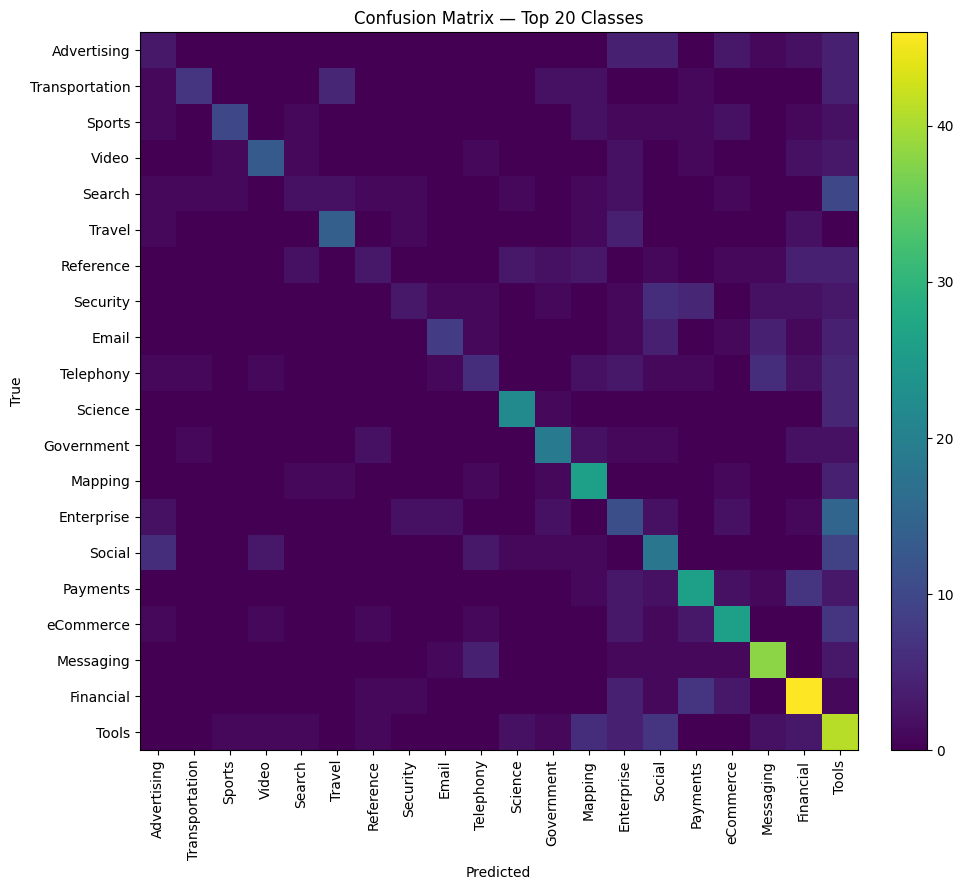


Saved LoRA adapter + tokenizer to: /kaggle/working/deepseek_r1_qwen1p5b_lora_demo

Sample 0: true=eCommerce
Top-3=[('eCommerce', 0.25694677233695984), ('Tools', 0.12166692316532135), ('Financial', 0.07663797587156296)]

Sample 1: true=Storage
Top-3=[('Cloud', 0.09788291156291962), ('Video', 0.06995145976543427), ('Tools', 0.05807831138372421)]

Sample 2: true=Medical
Top-3=[('Science', 0.3813992440700531), ('Medical', 0.28192946314811707), ('Government', 0.05191578343510628)]


In [16]:
# Test-set evaluation + classification report + confusion matrix + save LoRA adapter
import numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, os, json
from sklearn.metrics import classification_report, confusion_matrix
import torch

# ----- 1) Test metrics via Trainer -----
test_metrics = trainer.evaluate(eval_dataset=test_tok)
print("TEST METRICS:", test_metrics)

# ----- 2) Get logits/preds on test set -----
pred_out = trainer.predict(test_tok)
logits = pred_out.predictions
y_true = np.array(pred_out.label_ids)
y_pred = np.argmax(logits, axis=-1)

# ----- 3) Sklearn report (macro avg) -----
target_names = [id2label[i] for i in range(len(id2label))]
print("\nClassification Report (macro avg at bottom):")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# ----- 4) Confusion matrix (top-20 classes by support to keep plot readable) -----
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(id2label))))
support = cm.sum(axis=1)
topk = np.argsort(support)[-20:]  # top 20 classes by frequency
cm_top = cm[np.ix_(topk, topk)]
labels_top = [id2label[i] for i in topk]

plt.figure(figsize=(10, 9))
plt.imshow(cm_top, interpolation='nearest')
plt.title("Confusion Matrix — Top 20 Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(labels_top)), labels_top, rotation=90)
plt.yticks(range(len(labels_top)), labels_top)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ----- 5) Save LoRA adapter + tokenizer (for the demo handoff) -----
SAVE_DIR = "/kaggle/working/deepseek_r1_qwen1p5b_lora_demo"
os.makedirs(SAVE_DIR, exist_ok=True)

# save only the PEFT adapter (lightweight)
try:
    model.save_pretrained(SAVE_DIR)     # this will save PEFT adapter when model is a PEFT model
    tokenizer.save_pretrained(SAVE_DIR)
    # also persist label maps
    with open(os.path.join(SAVE_DIR, "label_maps.json"), "w") as f:
        json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)
    print(f"\nSaved LoRA adapter + tokenizer to: {SAVE_DIR}")
except Exception as e:
    print("Save error:", e)

# ----- 6) Quick sanity: show a few test samples with top-3 probabilities -----
import torch.nn.functional as F
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
topk_idx = np.argsort(-probs, axis=1)[:, :3]
for i in range(3):
    true_lbl = id2label[int(y_true[i])]
    top3 = [(id2label[j], float(probs[i, j])) for j in topk_idx[i]]
    print(f"\nSample {i}: true={true_lbl}\nTop-3={top3}")

In [17]:
# Phase-05 — Explainers need a predict_proba([str,...]) function

import numpy as np
import torch
import torch.nn.functional as F

model.eval()
device = next(model.parameters()).device

@torch.no_grad()
def predict_proba(text_list):
    """
    Args:
        text_list: List[str] texts.
    Returns:
        probs: np.ndarray of shape [N, num_labels] with class probabilities.
    """
    # Tokenize with same settings used in training
    enc = tokenizer(
        text_list,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    # Forward pass
    out = model(**enc)
    # HF seq cls returns logits in out.logits
    logits = out.logits  # [N, num_labels]
    probs = F.softmax(logits, dim=-1).cpu().numpy()
    return probs

# Quick sanity check on a few test samples
sample_texts = list(test_df["Service Description"].head(3).astype(str).values)
probs = predict_proba(sample_texts)
print("probs shape:", probs.shape)
for i, p in enumerate(probs):
    top3 = np.argsort(-p)[:3]
    print(f"\nSample {i}:")
    for j in top3:
        print(f"  {id2label[j]:>20s}: {p[j]:.3f}")

probs shape: (3, 50)

Sample 0:
             eCommerce: 0.259
                 Tools: 0.120
             Financial: 0.076

Sample 1:
                 Cloud: 0.099
                 Video: 0.070
                 Tools: 0.057

Sample 2:
               Science: 0.382
               Medical: 0.284
            Government: 0.052


In [23]:
# === Cell 10 — SHAP (robust wrapper to accept SHAP's numpy/nested inputs) ===
import shap
import numpy as np

# 1) pick a few texts to explain
N_EXPLAIN = 3
texts_to_explain = test_df["Service Description"].astype(str).head(N_EXPLAIN).tolist()

# 2) background texts (small for speed)
bg_texts = train_df["Service Description"].astype(str).sample(50, random_state=0).tolist()

# 3) SHAP text masker (default whitespace tokenizer)
masker = shap.maskers.Text()

def _to_text_list(x):
    """
    Normalize SHAP's input into List[str].
    Handles numpy arrays, lists, nested lists, None, and non-str objects.
    """
    # unwrap tuple from SHAP if present
    if isinstance(x, tuple) and len(x) == 1:
        x = x[0]
    # numpy -> list
    if isinstance(x, np.ndarray):
        x = x.tolist()
    # single string -> list
    if isinstance(x, str):
        x = [x]
    # ensure a flat list of strings
    out = []
    for item in x:
        if item is None:
            out.append("")
        elif isinstance(item, str):
            out.append(item)
        elif isinstance(item, (list, tuple, np.ndarray)):
            # join tokens if SHAP gives tokenized pieces
            out.append(" ".join([t for t in item if isinstance(t, str)]))
        else:
            out.append(str(item))
    return out

# Wrap our prob fn so SHAP can call it with any shape/type
def shap_predict_fn(x):
    texts = _to_text_list(x)
    return predict_proba(texts)

# Build explainer (model-agnostic, text masker)
explainer = shap.Explainer(
    shap_predict_fn,
    masker,
    output_names=[id2label[i] for i in range(len(id2label))]
)

# Compute explanations (keep evals modest for speed)
shap_values = explainer(texts_to_explain, max_evals=600, batch_size=8)

  0%|          | 0/598 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [01:31<00:00, 17.88s/it]

  0%|          | 0/598 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [02:14, 44.94s/it]                       


In [27]:
# === Cell 11 (OOM-safe) — LIME + faithfulness with micro-batching, short seq len, and GPU flush ===
import os, gc, numpy as np, pandas as pd
from pathlib import Path
import torch
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# Make CUDA allocator less fragmentation-prone (best-effort)
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

OUT_DIR = Path("/kaggle/working/xai_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
class_names = [id2label[i] for i in range(len(id2label))]

# ---------- Lightweight predictor for XAI (shorter max_length + micro-batching) ----------
model.eval()
device = next(model.parameters()).device

@torch.inference_mode()
def predict_proba_xai(text_list, max_len=128, batch_size=4):
    """Memory-friendly probability predictor for LIME/faithfulness."""
    probs_all = []
    # ensure plain strings
    clean = []
    for t in text_list:
        if t is None:
            clean.append("")
        elif isinstance(t, str):
            clean.append(t)
        else:
            clean.append(str(t))
    # micro-batch
    for i in range(0, len(clean), batch_size):
        batch = clean[i:i+batch_size]
        enc = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt"
        )
        enc = {k: v.to(device, non_blocking=True) for k, v in enc.items()}
        out = model(**enc)
        probs = torch.softmax(out.logits, dim=-1).detach().cpu().numpy()
        probs_all.append(probs)
        # clear per-batch to reduce peak VRAM
        del enc, out, probs
        torch.cuda.empty_cache()
    return np.concatenate(probs_all, axis=0)

# Short list to explain (reuse earlier selection)
texts_to_explain = test_df["Service Description"].astype(str).head(3).tolist()

# ---------- LIME (reduced samples, robust token extraction) ----------
lime_explainer = LimeTextExplainer(class_names=class_names)
lime_pngs, lime_csvs = [], []

for i, txt in enumerate(texts_to_explain):
    base_probs = predict_proba_xai([txt])[0]
    pred_idx = int(np.argmax(base_probs))
    pred_lbl = class_names[pred_idx]

    exp = lime_explainer.explain_instance(
        txt,
        predict_proba_xai,
        num_features=12,
        labels=[pred_idx],
        num_samples=400,   # lighter than default 5000
    )

    # Get (token, weight) directly (no domain_mapper.feature_names)
    token_weights = exp.as_list(label=pred_idx)  # list[(str_token, float_weight)]
    dfw = pd.DataFrame(token_weights, columns=["token", "weight"]).sort_values("weight", ascending=False)

    # Save CSV
    csv_path = OUT_DIR / f"lime_sample_{i:02d}_pred-{pred_lbl}.csv"
    dfw.to_csv(csv_path, index=False)
    lime_csvs.append(str(csv_path))

    # Save bar plot PNG (top-12)
    plt.figure(figsize=(8, 4.5))
    top_df = dfw.head(12)[::-1]
    plt.barh(top_df["token"], top_df["weight"])
    plt.title(f"LIME token weights — sample {i} (pred: {pred_lbl})")
    plt.tight_layout()
    png_path = OUT_DIR / f"lime_sample_{i:02d}_pred-{pred_lbl}.png"
    plt.savefig(png_path, dpi=160)
    plt.close()
    lime_pngs.append(str(png_path))

    # Flush between samples
    torch.cuda.empty_cache(); gc.collect()

print("Saved LIME CSVs:")
for p in lime_csvs: print("  -", p)
print("Saved LIME PNGs:")
for p in lime_pngs: print("  -", p)

# ---------- Faithfulness (deletion) using LIME top-5 tokens ----------
faith_rows = []
for i, txt in enumerate(texts_to_explain):
    base_probs = predict_proba_xai([txt])[0]
    pred_idx = int(np.argmax(base_probs))
    pred_lbl = class_names[pred_idx]
    base_prob = float(base_probs[pred_idx])

    # read the CSV we just wrote
    dfw = pd.read_csv(OUT_DIR / f"lime_sample_{i:02d}_pred-{pred_lbl}.csv")
    top5 = [t.lower() for t in dfw.sort_values("weight", ascending=False)["token"].head(5).tolist()]

    # remove top-5 tokens and re-score
    words = txt.split()
    txt_mod = " ".join([w for w in words if w.lower() not in top5]) or ""
    new_probs = predict_proba_xai([txt_mod])[0]
    new_prob = float(new_probs[pred_idx])

    faith_rows.append({
        "sample_id": i,
        "pred_label": pred_lbl,
        "base_prob": round(base_prob, 4),
        "new_prob_after_deleting_top5": round(new_prob, 4),
        "delta": round(base_prob - new_prob, 4),
        "deleted_tokens": ", ".join(top5),
    })

    # flush memory
    torch.cuda.empty_cache(); gc.collect()

faith_df = pd.DataFrame(faith_rows)
faith_csv = OUT_DIR / "faithfulness_deletion_top5.csv"
faith_df.to_csv(faith_csv, index=False)
print("Saved faithfulness CSV:", faith_csv)

print("\nAll artifacts saved in:", OUT_DIR)

Saved LIME CSVs:
  - /kaggle/working/xai_outputs/lime_sample_00_pred-eCommerce.csv
  - /kaggle/working/xai_outputs/lime_sample_01_pred-Cloud.csv
  - /kaggle/working/xai_outputs/lime_sample_02_pred-Science.csv
Saved LIME PNGs:
  - /kaggle/working/xai_outputs/lime_sample_00_pred-eCommerce.png
  - /kaggle/working/xai_outputs/lime_sample_01_pred-Cloud.png
  - /kaggle/working/xai_outputs/lime_sample_02_pred-Science.png
Saved faithfulness CSV: /kaggle/working/xai_outputs/faithfulness_deletion_top5.csv

All artifacts saved in: /kaggle/working/xai_outputs


In [28]:
# === Cell 12 — Zip XAI outputs and prepare for download ===
import shutil
from pathlib import Path

OUT_DIR = Path("/kaggle/working/xai_outputs")
ZIP_PATH = "/kaggle/working/xai_outputs.zip"

# Create ZIP (overwrite if exists)
shutil.make_archive("/kaggle/working/xai_outputs", 'zip', OUT_DIR)

print("Created ZIP at:", ZIP_PATH)

# If running in Kaggle, use this to download:
from IPython.display import FileLink
FileLink(ZIP_PATH)

Created ZIP at: /kaggle/working/xai_outputs.zip


/kaggle/working/xai_outputs.zip

In [ ]:
# Visualize per-sample token coloring for the predicted class
shap.initjs()
for i in range(len(texts_to_explain)):
    print(f"\n=== SHAP explanation for sample {i} ===")
    display(shap.plots.text(shap_values[i]))